<a href="https://colab.research.google.com/github/annine1/Ensemble_Learning/blob/main/Ensemble_Learning_Project_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importation of Libraries

In [34]:
import pandas as pd
from random import randrange
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import collections
from collections import Counter
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score

from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator
from imblearn import over_sampling
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)


#Preprocessing of data

In [35]:
header_list = ["id_no", "C_Thickness", "Cell_Size","Cell_Shape","M_Adhesion","SEC_Size","B_Nuclei","B_Chromatin","N_Nucleoli","Mitoses","class"]

In [36]:
data = pd.read_csv('/content/drive/MyDrive/Bootcamp3/data/breast-cancer-wisconsin.csv',names=header_list)
data.head()

,id_no,C_Thickness,Cell_Size,Cell_Shape,M_Adhesion,SEC_Size,B_Nuclei,B_Chromatin,N_Nucleoli,Mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_no        699 non-null    int64 
 1   C_Thickness  699 non-null    int64 
 2   Cell_Size    699 non-null    int64 
 3   Cell_Shape   699 non-null    int64 
 4   M_Adhesion   699 non-null    int64 
 5   SEC_Size     699 non-null    int64 
 6   B_Nuclei     699 non-null    object
 7   B_Chromatin  699 non-null    int64 
 8   N_Nucleoli   699 non-null    int64 
 9   Mitoses      699 non-null    int64 
 10  class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


#### B_Nuclei is an object so we perform label enconding on B_Nuclei to transform it to category

In [39]:
#encoding B_Nuclei  to catergorical
label = LabelEncoder()
data['B_Nuclei'] = label.fit_transform(data['B_Nuclei'])
data.head()


,id_no,C_Thickness,Cell_Size,Cell_Shape,M_Adhesion,SEC_Size,B_Nuclei,B_Chromatin,N_Nucleoli,Mitoses,class
0,1000025,5,1,1,1,2,0,3,1,1,2
1,1002945,5,4,4,5,7,1,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,0,3,1,1,2


### We now have B_Nuclei as an int(categorical). We then drop id_no since it is not informative.

In [40]:
data.drop("id_no",axis=1,inplace=True) # We drop Id_no
data.head()

,C_Thickness,Cell_Size,Cell_Shape,M_Adhesion,SEC_Size,B_Nuclei,B_Chromatin,N_Nucleoli,Mitoses,class
0,5,1,1,1,2,0,3,1,1,2
1,5,4,4,5,7,1,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,0,3,1,1,2


In [41]:
print(data.isnull().sum()) # checking for missing values

C_Thickness    0
Cell_Size      0
Cell_Shape     0
M_Adhesion     0
SEC_Size       0
B_Nuclei       0
B_Chromatin    0
N_Nucleoli     0
Mitoses        0
class          0
dtype: int64


2    458
4    241
Name: class, dtype: int64


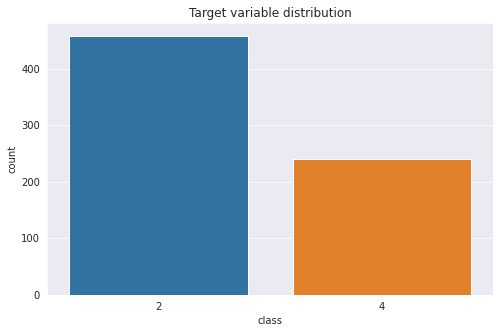

In [42]:
print(data['class'].value_counts()) # class distribution
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(data["class"])
plt.title('Target variable distribution')
plt.show()

#Splitting data

In [43]:
def split(data,percent):
  np.random.seed(42)
  perm = np.random.permutation(data.index)
  n = len(data)

  train_size = int(percent* n)
  train_data = data.iloc[:perm[train_size]:]
  test_data  = data.iloc[perm[train_size]:]
  x_train = train_data.iloc[: , :-1 ]
  y_train =  train_data.iloc[ : , -1 ]

  x_test  = test_data.iloc[: , :-1 ]
  y_test  = test_data.iloc[ : , -1 ]

  return x_train,y_train, x_test,y_test

x_train,y_train, x_test,y_test =split(data,0.75)

In [44]:
x_train.shape,y_train.shape , x_test.shape,y_test.shape

((541, 9), (541,), (158, 9), (158,))

In [45]:
y_train.value_counts() # to show the number of datapoints per class in train set

2    337
4    204
Name: class, dtype: int64

In [46]:
y_test.value_counts() # to show the number of datapoints per class in test set

2    121
4     37
Name: class, dtype: int64

#Tackling Imbalance dataset

We have observed that the data is umbalanced per class. To solve this issue of imbalance data we use these techniques:
- Oversampling : Increasing the minority class. eg SMOTE, Random oversampler

- Undersampling : Decrease the majority class. eg tumor link, Random Undersampler

- Hybrid Approach 


In [47]:
#. for undersampling
def under_sampler(X, y):
  undersample = RandomUnderSampler(sampling_strategy='majority') #instantiate the model
  X_under, y_under= undersample.fit_resample(X, y)   # fit and apply the transform

  return X_under,y_under

# for oversampling
def over_sampler(X, y):
  oversample = RandomOverSampler(sampling_strategy='minority') #instantiate the model
  X_over,y_over= oversample.fit_resample(X, y)   # fit and apply the transform
  
  return X_over,y_over

In [48]:
x_under, y_under = under_sampler(x_train, y_train)
print(x_under.shape, y_under.shape)
y_under.value_counts() 

(408, 9) (408,)


2    204
4    204
Name: class, dtype: int64

In [49]:
x_over, y_over = over_sampler(x_train, y_train)
print(x_over.shape, y_over.shape)

y_over.value_counts() 

(674, 9) (674,)


2    337
4    337
Name: class, dtype: int64

# Instantiating models from sklearn

In [72]:
logistic = LogisticRegression() # instantiating the model
svm = SVC()
trees = DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
#tree = DecisionTreeClassifier(criterion = "gini",random_state = 42,max_depth=6, min_samples_leaf=5)

In [73]:
print("logistic")
log_under = logistic.fit(x_under,y_under)
log_under.fit(x_under,y_under)
pred_underlog =log_under.predict(x_test)
print('--------------------underSampling----------------------------')
print(accuracy_score(y_test, pred_underlog) )
print(f'{classification_report(y_test, pred_underlog)}') 
print(f'{confusion_matrix(y_test, pred_underlog)}') 

print('-------------------OverSampling-----------------------------')
log_over = logistic.fit(x_over,y_over)
pred_overlog = log_over.predict(x_test)
print(accuracy_score(y_test, pred_overlog) )
print(f'{classification_report(y_test, pred_overlog)}') 
print(f'{confusion_matrix(y_test, pred_overlog)}') 

logistic
--------------------underSampling----------------------------
0.9873417721518988
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158

[[119   2]
 [  0  37]]
-------------------OverSampling-----------------------------
0.9873417721518988
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158

[[119   2]
 [  0  37]]


In [74]:
print("svm")
svm_under = svm.fit(x_under,y_under)
pred_under_svc = svm_under.predict(x_test)

print('-------------------underSampling-----------------------------')
print(accuracy_score(y_test, pred_under_svc) )
print(f'{classification_report(y_test, pred_under_svc)}') 
print(f'{confusion_matrix(y_test, pred_under_svc)}') 

print('-------------------OverSampling-----------------------------')
svm_over = svm.fit(x_over,y_over)
pred_over_svc = svm_over.predict(x_test)
print(accuracy_score(y_test, pred_over_svc) )
print(f'{classification_report(y_test, pred_over_svc)}') 
print(f'{confusion_matrix(y_test, pred_over_svc)}') 

svm
-------------------underSampling-----------------------------
0.9873417721518988
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158

[[119   2]
 [  0  37]]
-------------------OverSampling-----------------------------
0.9873417721518988
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158

[[119   2]
 [  0  37]]


In [75]:
print("decision tree")
trees_under = trees.fit(x_under,y_under)
pred_under_trees = trees_under.predict(x_test)

print('--------------------underSampling----------------------------')
print(accuracy_score(y_test, pred_under_trees) )
print(f'{classification_report(y_test, pred_under_trees)}') 
print(f'{confusion_matrix(y_test, pred_under_trees)}') 

print('-------------------OverSampling-----------------------------')
trees_over = trees.fit(x_over,y_over)
pred_over_trees = trees_over.predict(x_test)
print(accuracy_score(y_test, pred_under_trees) )
print(f'{classification_report(y_test, pred_under_trees)}') 
print(f'{confusion_matrix(y_test, pred_under_trees)}') 

decision tree
--------------------underSampling----------------------------
0.9620253164556962
              precision    recall  f1-score   support

           2       0.99      0.96      0.97       121
           4       0.88      0.97      0.92        37

    accuracy                           0.96       158
   macro avg       0.93      0.97      0.95       158
weighted avg       0.96      0.96      0.96       158

[[116   5]
 [  1  36]]
-------------------OverSampling-----------------------------
0.9620253164556962
              precision    recall  f1-score   support

           2       0.99      0.96      0.97       121
           4       0.88      0.97      0.92        37

    accuracy                           0.96       158
   macro avg       0.93      0.97      0.95       158
weighted avg       0.96      0.96      0.96       158

[[116   5]
 [  1  36]]


In [76]:
print("mlp")
mlp_under = mlp.fit(x_under,y_under)
pred_under_mlp =  mlp_under.predict(x_test)

print('-------------------OverSampling-----------------------------')
print(accuracy_score(y_test, pred_under_mlp) )
print(f'{classification_report(y_test, pred_under_mlp)}') 
print(f'{confusion_matrix(y_test, pred_under_mlp)}') 

print('-------------------underSampling-----------------------------')
mlp_over = mlp.fit(x_over,y_over)
pred_over_trees = mlp_over.predict(x_test)
print(accuracy_score(y_test, pred_under_mlp) )
print(f'{classification_report(y_test, pred_under_mlp)}') 
print(f'{confusion_matrix(y_test, pred_under_mlp)}')


mlp
-------------------OverSampling-----------------------------
0.9810126582278481
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.93      1.00      0.96        37

    accuracy                           0.98       158
   macro avg       0.96      0.99      0.97       158
weighted avg       0.98      0.98      0.98       158

[[118   3]
 [  0  37]]
-------------------underSampling-----------------------------
0.9810126582278481
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.93      1.00      0.96        37

    accuracy                           0.98       158
   macro avg       0.96      0.99      0.97       158
weighted avg       0.98      0.98      0.98       158

[[118   3]
 [  0  37]]


#Ensembling Methods

Ensemble method consists of several ML algorithms, pooling them together to achieve a better quality prediction. These methods include;
- Bagging
- voting
- stacking
- Boosting

# Over Sampling:

##Voting

In [55]:
def voting(x_over, y_over,x_test,y_test,models):
  predictions = np.zeros((len(y_test),len(models) ))
  for m  in range(len(models)):
    model=models[m].fit(x_over, y_over)
    predictions[:,m] = model.predict(x_test)
  
  ''' Here, we compute the majority voting.'''
  predictions = pd.DataFrame(predictions)  
  final_predictions = [max(set(list(predictions.values[i])),key=list(predictions.values[i]).count) for i in range(len(predictions))]
  return final_predictions



def accuracy(y_test,ypred):
  # out=0
  n=len(y_test)
  out = np.sum([1 if y_test.iloc[i]==ypred[i] else 0 for i in range(len(y_test))])
  return out/n

In [56]:
models = [logistic,trees,svm,mlp]
vote = voting(x_over, y_over,x_test,y_test,models)
print('Accuracy: ',(accuracy(y_test,vote)))
print(classification_report(y_test, vote))
print(f'{confusion_matrix(y_test, vote)}') 

Accuracy:  0.9873417721518988
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158

[[119   2]
 [  0  37]]


Undersampling

In [57]:
models = [logistic,trees,svm,mlp]
vote_under = voting(x_under, y_under,x_test,y_test,models)
print('Accuracy: ', accuracy(y_test,vote_under))
print(f'{classification_report(y_test, vote_under)}')
print(f'{confusion_matrix(y_test, vote_under)}') 

Accuracy:  0.9873417721518988
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158

[[119   2]
 [  0  37]]


In [58]:
accuracy(y_test,vote_under)


0.9873417721518988

##Bagging

In [59]:
'''Combining the dataset in order to get the training data.'''
over_train = x_over.join(y_over) 
under_train = x_under.join(y_under) 

In [60]:
'''This function outputs the different samples from the same training dataset. Note : the sample is a random sample with replacement.'''
def bootstrap_sample(original_dataset, ratio): 
    sub_dataset = []
    n_elt = round(len(original_dataset)*ratio) 
    for i in range(n_elt):
      '''the index outputs a random index of a datapoint from training dataset.'''
      index = randrange(len(original_dataset)) 

      sub_dataset.append(original_dataset.values[index])
    return sub_dataset

def build_tree(x_train,y_train):
  # tree = DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)
  # tree = SVC()
  # tree = LogisticRegression()
  tree = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
  tree.fit(x_train,y_train)
  return tree 

''' Make a prediction with a list of bagged trees'''
def bagging_predict(tree,x):
  pred = tree.predict(x)
  return pred

def bagging(xx_train,x_test,y,n_trees):
  predictions = np.zeros((len(y),n_trees))
  trees = []
  for i in range(n_trees):
    sample = bootstrap_sample(xx_train,0.4)
    sample = pd.DataFrame(sample)
    tree = build_tree(sample.iloc[:,:-1],sample.iloc[:,-1])
    # print(tree)
    predictions[:,i] = bagging_predict(tree,x_test)

    ''' majority voting'''
  predictions = pd.DataFrame(predictions)
  # print(predictions)
  final_predictions = [max(set(list(predictions.values[i])),key=list(predictions.values[i]).count) for i in range(len(predictions))]
  return final_predictions

''' to call the bagging function, we use the syntax ;
out=bagging(xx_train,x_test,y_test,5)
out=pd.DataFrame(out)
'''



def accuracy(y_test,ypred):
  ''' we compute the accuracy of our predictions from the bagging method.'''
  # out=0
  n=len(y_test)
  out = np.sum([1 if y_test.values[i]==ypred.values[i] else 0 for i in range(len(y_test))])
  return out/n



In [61]:
bag_over = bagging(over_train,x_test,y_test,5)
bag_over=pd.DataFrame(bag_over)

print('-------------------OverSampling-----------------------------')
print('Accuracy: ',accuracy(y_test,bag_over))
print(confusion_matrix(y_test,bag_over))
print(classification_report(y_test,bag_over))

print('-------------------UnderSampling----------------------------')
bag_under = bagging(under_train,x_test,y_test,5)
bag_under=pd.DataFrame(bag_under)

print('Accuracy: ', accuracy(y_test,bag_under))
print(confusion_matrix(y_test,bag_under))
print(classification_report(y_test,bag_under))


-------------------OverSampling-----------------------------
Accuracy:  0.9810126582278481
[[118   3]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.93      1.00      0.96        37

    accuracy                           0.98       158
   macro avg       0.96      0.99      0.97       158
weighted avg       0.98      0.98      0.98       158

-------------------UnderSampling----------------------------
Accuracy:  0.9873417721518988
[[119   2]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158



SVM

In [62]:
bag_over_svm = bagging(over_train,x_test,y_test,5)
bag_over_svm=pd.DataFrame(bag_over_svm)

print('-------------------OverSampling-----------------------------')
print('Accuracy: ',accuracy(y_test,bag_over_svm))
print(confusion_matrix(y_test,bag_over_svm))
print(classification_report(y_test,bag_over_svm))

print('-------------------UnderSampling----------------------------')
bag_under_svm = bagging(under_train,x_test,y_test,5)
bag_under_svm=pd.DataFrame(bag_under_svm)

print('Accuracy: ', accuracy(y_test,bag_under_svm))
print(confusion_matrix(y_test,bag_under_svm))
print(classification_report(y_test,bag_under_svm))


-------------------OverSampling-----------------------------
Accuracy:  0.9873417721518988
[[119   2]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158

-------------------UnderSampling----------------------------
Accuracy:  0.9746835443037974
[[118   3]
 [  1  36]]
              precision    recall  f1-score   support

           2       0.99      0.98      0.98       121
           4       0.92      0.97      0.95        37

    accuracy                           0.97       158
   macro avg       0.96      0.97      0.97       158
weighted avg       0.98      0.97      0.97       158



LogisticRegression

In [63]:
bag_over_logist = bagging(over_train,x_test,y_test,5)
bag_over_logist=pd.DataFrame(bag_over_logist)

print('-------------------OverSampling-----------------------------')
print('Accuracy: ',accuracy(y_test,bag_over_logist))
print(confusion_matrix(y_test,bag_over_logist))
print(classification_report(y_test,bag_over_logist))

print('-------------------UnderSampling----------------------------')
bag_under_logist = bagging(under_train,x_test,y_test,5)
bag_under_logist=pd.DataFrame(bag_under_logist)

print('Accuracy: ', accuracy(y_test,bag_under_logist))
print(confusion_matrix(y_test,bag_under_logist))
print(classification_report(y_test,bag_under_logist))


-------------------OverSampling-----------------------------
Accuracy:  0.9873417721518988
[[119   2]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158

-------------------UnderSampling----------------------------
Accuracy:  0.9936708860759493
[[121   0]
 [  1  36]]
              precision    recall  f1-score   support

           2       0.99      1.00      1.00       121
           4       1.00      0.97      0.99        37

    accuracy                           0.99       158
   macro avg       1.00      0.99      0.99       158
weighted avg       0.99      0.99      0.99       158



FCN

In [64]:
bag_over_FCN = bagging(over_train,x_test,y_test,5)
bag_over_FCN=pd.DataFrame(bag_over_FCN)

print('-------------------OverSampling-----------------------------')
print('Accuracy: ',accuracy(y_test,bag_over_FCN))
print(confusion_matrix(y_test,bag_over_FCN))
print(classification_report(y_test,bag_over_FCN))

print('-------------------UnderSampling----------------------------')
bag_under_FCN = bagging(under_train,x_test,y_test,5)
bag_under_FCN=pd.DataFrame(bag_under_FCN)

print('Accuracy: ', accuracy(y_test,bag_under_FCN))
print(confusion_matrix(y_test,bag_under_FCN))
print(classification_report(y_test,bag_under_FCN))


-------------------OverSampling-----------------------------
Accuracy:  0.9873417721518988
[[119   2]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158

-------------------UnderSampling----------------------------
Accuracy:  0.9810126582278481
[[119   2]
 [  1  36]]
              precision    recall  f1-score   support

           2       0.99      0.98      0.99       121
           4       0.95      0.97      0.96        37

    accuracy                           0.98       158
   macro avg       0.97      0.98      0.97       158
weighted avg       0.98      0.98      0.98       158



##Boosting

In [65]:
class adaBoostClassifier():
  def __init__(self, n_estimators=4, max_depth=1, max_leaf_nodes=3, random_state=None):
    self.n_estimators = n_estimators
    self.max_depth = max_depth
    self.max_leaf_nodes = max_leaf_nodes
    self.random_state = random_state
    self.sample_weight = np.array([])
    self.weight_model = dict()
    self.model = dict()
    self.features = dict()

  def fit(self, x, y):

    # weigth initialization
    x_length = len(x)
    self.sample_weight = np.ones(x_length)/x_length


    np.random.seed(seed=9999)
    for i in range(self.n_estimators) :

      # randomly select a sample
      rand_index = np.random.randint(low=0, high=x.shape[0], size=round(x.shape[0]*0.8))
      rand_column = np.random.randint(low=0, high=x.shape[1], size=round(x.shape[1]*0.8))

      x_samp = x.iloc[rand_index, :]
      x_samp = x_samp.iloc[:, rand_column]
      y_samp = y.iloc[rand_index]
      weight_samp = self.sample_weight[rand_index]

      # Initialize the model (decision tree)
      # decision_tree_model = DecisionTreeClassifier(max_leaf_nodes=self.max_leaf_nodes, random_state=self.random_state, max_depth=self.max_depth)

      # Initialize the model (svm)
      # decision_tree_model = SVC()

      # Initialize the model (svm)
      # decision_tree_model = LogisticRegression()

      # Initialize the model (svm)
      decision_tree_model = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)

      # fit the model
      self.model[i] = decision_tree_model.fit(x_samp, y_samp)
      # self.model[i] = decision_tree_model.fit(x_samp, y_samp, sample_weight=weight_samp)
      self.features[i] = rand_column

      # Prediction 
      y_pred = self.model[i].predict(x_samp)

      # Compute the total erreur
      total_error = np.sum((y_pred!=y_samp) * weight_samp)

      # Compute the weight of the model
      self.weight_model[i] = (1/2) * np.log((1-total_error)/(total_error))

      # updating the weight
      self.sample_weight[rand_index] = (y_pred!=y_samp) * self.sample_weight[rand_index] * np.exp(self.weight_model[i]) + (y_pred==y_samp) * self.sample_weight[rand_index] * np.exp(-self.weight_model[i])
  
      # Normalize the weight  
      self.sample_weight /= np.sum(self.sample_weight)


  def predict(self, x):

    pred = np.zeros(x.shape[0])
    for i in range(self.n_estimators):
      pred += self.model[i].predict(x.iloc[:, self.features[i]]) * self.weight_model[i]

    pred = pred/self.n_estimators
    pred = np.where(pred <= 3, 2, 4)

    return pred



In [66]:
ada = adaBoostClassifier(n_estimators=4, random_state=42)
ada.fit(x_over, y_over)

ada_under = adaBoostClassifier(n_estimators=4, random_state=42)
ada_under.fit(x_under, y_under)

In [68]:
print('---------------------------OverSampling--------------------------')
pred_over = ada.predict(x_test)
print('Accuracy: ',accuracy(y_test,pd.DataFrame(pred_over)))
print(confusion_matrix(y_test,pred_over))
print(classification_report(y_test,pred_over))

print('----------------------------underSampling-----------------------------')
pred_under = ada_under.predict(x_test)
print('accuracy: ', accuracy(y_test,pd.DataFrame(pred_under)))
print(confusion_matrix(y_test,pred_under))
print(classification_report(y_test,pred_under))

---------------------------OverSampling--------------------------
Accuracy:  0.9683544303797469
[[116   5]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.96      0.98       121
           4       0.88      1.00      0.94        37

    accuracy                           0.97       158
   macro avg       0.94      0.98      0.96       158
weighted avg       0.97      0.97      0.97       158

----------------------------underSampling-----------------------------
accuracy:  0.9873417721518988
[[119   2]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158



SVM

In [67]:
ada_svm = adaBoostClassifier(n_estimators=4, random_state=42)
ada_svm.fit(x_over, y_over)

ada_under_svm = adaBoostClassifier(n_estimators=4, random_state=42)
ada_under_svm.fit(x_under, y_under)

print('---------------------------OverSampling--------------------------')
pred_over_svm = ada_svm.predict(x_test)
print('Accuracy SVM: ',accuracy(y_test,pd.DataFrame(pred_over_svm)))
print(confusion_matrix(y_test,pred_over_svm))
print(classification_report(y_test,pred_over_svm))

print('----------------------------underSampling-----------------------------')
pred_under_svm = ada_under_svm.predict(x_test)
print('accuracy SVM: ', accuracy(y_test,pd.DataFrame(pred_under_svm)))
print(confusion_matrix(y_test,pred_under_svm))
print(classification_report(y_test,pred_under_svm))

---------------------------OverSampling--------------------------
Accuracy SVM:  0.9683544303797469
[[116   5]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.96      0.98       121
           4       0.88      1.00      0.94        37

    accuracy                           0.97       158
   macro avg       0.94      0.98      0.96       158
weighted avg       0.97      0.97      0.97       158

----------------------------underSampling-----------------------------
accuracy SVM:  0.9873417721518988
[[119   2]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158



LogisticRegression

In [69]:
ada_logis = adaBoostClassifier(n_estimators=4, random_state=42)
ada_logis.fit(x_over, y_over)

ada_under_logis = adaBoostClassifier(n_estimators=4, random_state=42)
ada_under_logis.fit(x_under, y_under)

print('---------------------------OverSampling--------------------------')
pred_over_logis = ada_logis.predict(x_test)
print('Accuracy logis: ',accuracy(y_test,pd.DataFrame(pred_over_logis)))
print(confusion_matrix(y_test,pred_over_logis))
print(classification_report(y_test,pred_over_logis))

print('----------------------------underSampling-----------------------------')
pred_under_logis = ada_under_logis.predict(x_test)
print('accuracy logis: ', accuracy(y_test,pd.DataFrame(pred_under_logis)))
print(confusion_matrix(y_test,pred_under_logis))
print(classification_report(y_test,pred_under_logis))

---------------------------OverSampling--------------------------
Accuracy logis:  0.9683544303797469
[[116   5]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.96      0.98       121
           4       0.88      1.00      0.94        37

    accuracy                           0.97       158
   macro avg       0.94      0.98      0.96       158
weighted avg       0.97      0.97      0.97       158

----------------------------underSampling-----------------------------
accuracy logis:  0.9873417721518988
[[119   2]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158



FCN

In [70]:
ada_FCN = adaBoostClassifier(n_estimators=4, random_state=42)
ada_FCN.fit(x_over, y_over)

ada_under_FCN = adaBoostClassifier(n_estimators=4, random_state=42)
ada_under_FCN.fit(x_under, y_under)

print('---------------------------OverSampling--------------------------')
pred_over_FCN = ada_FCN.predict(x_test)
print('Accuracy FCN: ',accuracy(y_test,pd.DataFrame(pred_over_FCN)))
print(confusion_matrix(y_test,pred_over_FCN))
print(classification_report(y_test,pred_over_FCN))

print('----------------------------underSampling-----------------------------')
pred_under_FCN = ada_under_FCN.predict(x_test)
print('accuracy FCN: ', accuracy(y_test,pd.DataFrame(pred_under_FCN)))
print(confusion_matrix(y_test,pred_under_FCN))
print(classification_report(y_test,pred_under_FCN))

---------------------------OverSampling--------------------------
Accuracy FCN:  0.9683544303797469
[[116   5]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.96      0.98       121
           4       0.88      1.00      0.94        37

    accuracy                           0.97       158
   macro avg       0.94      0.98      0.96       158
weighted avg       0.97      0.97      0.97       158

----------------------------underSampling-----------------------------
accuracy FCN:  0.9873417721518988
[[119   2]
 [  0  37]]
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       121
           4       0.95      1.00      0.97        37

    accuracy                           0.99       158
   macro avg       0.97      0.99      0.98       158
weighted avg       0.99      0.99      0.99       158

